## Reimplementing Faster R-CNN using TensorFlow.

### Steps
 1. Create the convolutional layers, by taking a model pretrained on ImageNet and use Transfer Learning.


### Resources

 For transfer learning from MobileNet V2:
 1. https://www.tensorflow.org/tutorials/images/transfer_learning
 2. https://arxiv.org/pdf/1506.01497.pdf
 3. https://www.youtube.com/watch?v=nDPWywWRIRo
 
### TODO 

1. Faster R-Cnn uses the Regional proposal network to propose regions and it uses Fast R-CNN to fine-tune the detection and classify the objects. Fast R-CNN is not implemented yet.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

In [2]:
dataset = tfds.load(name="voc", split=tfds.Split.TRAIN)

classes = [ 'Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle', 'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable', 
           'Dog', 'Horse', 'Motorbike', 'Person','Pottedplant', 'Sheep', 'Sofa', 'Train', 'Tvmonitor']

# In the paper for images they kept the ratio, in mine the images were made square
IMG_SIZE = 600   
def preprocess(row):
    row['image'] = tf.image.resize(row['image'], (IMG_SIZE, IMG_SIZE))
    row['image'] = row['image'] / 255  
    return {'image':row['image'], 'labels':row['labels'], 'objects':row['objects'], 'filename':row['image/filename']}

dataset = dataset.map(lambda row: preprocess(row))

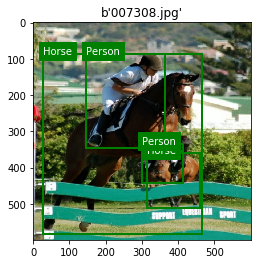

In [3]:
def bbox_perc_to_pixels(bbox):
    y_start, y_finish = bbox[0] * IMG_SIZE, bbox[2] * IMG_SIZE
    x_start, x_finish = bbox[1] * IMG_SIZE, bbox[3] * IMG_SIZE
    return y_start, x_start, y_finish, x_finish

for row in dataset.take(1):    
    _, ax = plt.subplots(1)
    ax.imshow(row['image'].numpy().astype(float))
    
    for bbox, label in zip(row['objects']['bbox'].numpy(), row['objects']['label'].numpy()):
        y_start, x_start, y_finish, x_finish = bbox_perc_to_pixels(bbox)
        
        rect = patches.Rectangle((x_start, y_start), x_finish-x_start, y_finish-y_start, linewidth=2,
                                 edgecolor='green', facecolor='none')
        ax.add_patch(rect)       
        plt.text(x_start, y_start, classes[label], color='white', backgroundcolor='green')
    
    plt.title(row['filename'].numpy())
    plt.show()

In [5]:
TRAIN_SIZE=100 # 2000 

dataset.shuffle(buffer_size=2501)
train = dataset.take(TRAIN_SIZE)
validation = dataset.skip(TRAIN_SIZE).take(250)
testing = dataset.skip(TRAIN_SIZE + 250).take(250)

images_dataset = np.zeros((TRAIN_SIZE, IMG_SIZE, IMG_SIZE, 3))
for i, row in enumerate(train):
    images_dataset[i] = row['image'].numpy().astype(float)

At each sliding-window location, we simultanously predict multiple regions proposals:
1. "reg" layer has 4k outputs encoding the coordinates of k boxes (k=9: 3 shape ratios & 3 shape sizes)
    * the 4 outputs are: x, y, w & h: the box center coordinates and its width and height (see loss function)
2. "cls" layer outputs 2k scores that estimate probability of object or not for each proposal. (this is
    implemented  as a 2-class softmax layer)

In [6]:
# In preprocess_data.ipynb (in the same folder as this notebook) are the functions 
# that process the values used for regression (distance from anchor to ground truth object) 
# and classification (intersection over union) labels used by the Region Proposing Network
%run preprocess_data.ipynb

def run_processing():
    regression_values_dataset = np.zeros((TRAIN_SIZE,17,17,3,3,4))
    classification_values_dataset = np.zeros((TRAIN_SIZE,17,17,3,3))

    for i, row in enumerate(train):
        regression_values_dataset[i], classification_values_dataset[i] = prepare_output_values(row)
    return regression_values_dataset, classification_values_dataset
    
regression_values_dataset, classification_values_dataset = run_processing()

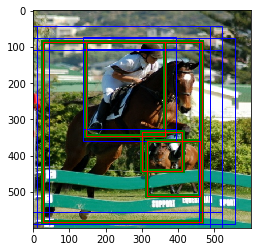

In [7]:
def draw_all_groundtruth_objects(row, ax):
    for bbox, label in zip(row['objects']['bbox'].numpy(), row['objects']['label'].numpy()):
        y_start, x_start, y_finish, x_finish = bbox_perc_to_pixels(bbox)
        
        rect = patches.Rectangle((x_start, y_start), x_finish-x_start, y_finish-y_start, linewidth=4,
                                 edgecolor='green', facecolor='none')
        ax.add_patch(rect)

# Here we test that we created the regression values correctly.
# Meaning that we take 3 random anchors together with their regression values, 
# and together they will describe a ground-truth object.
def test_train_data():
    scale = IMG_SIZE / 17
    for im, row in enumerate(train.take(1)):   
        image = row['image'].numpy().astype(float)
        plt.imshow(image)
        ax = plt.gca()

        draw_all_groundtruth_objects(row, ax)

        for i, row in enumerate(anchors_map):
            for j, column in enumerate(row):
                for r, ratio in enumerate(column):
                    for s, size in enumerate(ratio):

                        distance = regression_values_dataset[im][i,j,r,s]

                        groundtruth_x1, groundtruth_y1, groundtruth_width, groundtruth_height = \
                            anchor_and_distance_to_groundtruth(
                                anchors_map['y1'][i,j,r,s], 
                                anchors_map['x1'][i,j,r,s], 
                                anchors_map['y2'][i,j,r,s],
                                anchors_map['x2'][i,j,r,s], distance)

                        rect = patches.Rectangle((groundtruth_x1, groundtruth_y1), 
                                                groundtruth_width, groundtruth_height, 
                                                linewidth=1, edgecolor='red', facecolor='none')
                        ax.add_patch(rect)

                        if classification_values_dataset[im][i,j,r,s] > 0.75:
                            rect = patches.Rectangle((anchors_map['x1'][i,j,r,s], anchors_map['y1'][i,j,r,s]), 
                                                anchors_map['x2'][i,j,r,s] - anchors_map['x1'][i,j,r,s], 
                                                anchors_map['y2'][i,j,r,s] - anchors_map['y1'][i,j,r,s],
                                                linewidth=1, edgecolor='blue', facecolor='none')
                            ax.add_patch(rect)

        plt.show()
    
# Green is the round truth object. 
# Red is the anchor + regression offset object.
# Blue is an anchor that has IOU > 0.75 with a ground-truth object

# The fact that we can see a red line through every green lines, means that we covered all boxes correctly.
test_train_data()

In [8]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False, 
                                               weights='imagenet')
base_model.trainable = False

# To increase performance we will train the top layers of the RegionProposalNetwork 
# separately from the convolutional layers. We can do this because the conv. layers are frozen 
# (their weights are not changed)

# First we get the output of the convolutional layers for each of the train images:
convolutions_output = base_model.predict(images_dataset)

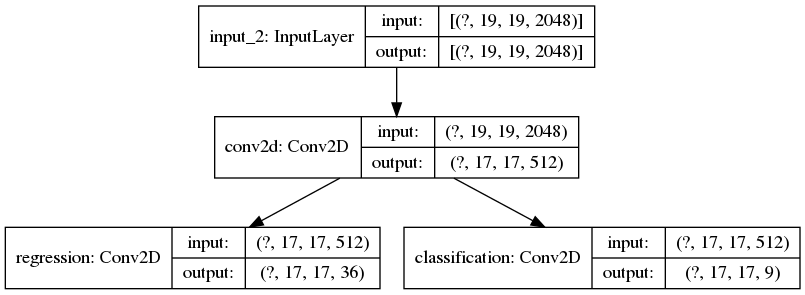

In [9]:
from tensorflow.compat.v1.keras.initializers import RandomNormal

#https://www.tensorflow.org/guide/keras/functional
inputs = tf.keras.Input(shape=(19, 19, 2048))

c = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', 
        bias_initializer='zeros', kernel_initializer=RandomNormal(mean=0.0, stddev=0.1))(inputs)

regression = tf.keras.layers.Conv2D(36, (1, 1), bias_initializer='zeros', 
                            kernel_initializer=RandomNormal(mean=0.0, stddev=0.01), name='regression')(c)

# I cannot have softmax here because I'm predicting  multiple types of shapes and they all can have 100%
classification = tf.keras.layers.Conv2D(9, (1, 1), bias_initializer='zeros', 
                            kernel_initializer=RandomNormal(mean=0.0, stddev=0.001), name='classification')(c)

model = tf.keras.Model(inputs=inputs, outputs=[regression, classification])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              loss={'regression': 'mae', # 'mse', # TODO Is mae the right one?
                    'classification': 'mae', # 'mse',  #tf.losses.BinaryCrossentropy()
                   }
             )
#model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [11]:
history = model.fit(x=convolutions_output,
                    y={'regression': regression_values_dataset.reshape((-1,17,17,36)),
                      'classification': classification_values_dataset.reshape((-1,17,17,9))
                      },
                    batch_size=1,
                    epochs=3
                    #TODO: validation_data=validation_batches
                   )

Train on 100 samples
Epoch 1/3
100/100 [==============================] - 26s 260ms/sample - loss: 3.4959 - regression_loss: 0.8946 - classification_loss: 2.6013
Epoch 2/3
100/100 [==============================] - 29s 292ms/sample - loss: 0.6042 - regression_loss: 0.4852 - classification_loss: 0.1190
Epoch 3/3
100/100 [==============================] - 38s 382ms/sample - loss: 0.5858 - regression_loss: 0.4699 - classification_loss: 0.1159


In [18]:
# learning_rate /= 10 and continued the training 
#Epoch 3/3 1000/1000 - 428s 428ms/sample - loss: 0.5313 - regression_loss: 0.4391 - classification_loss: 0.0922

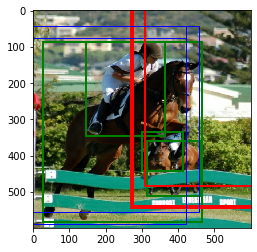

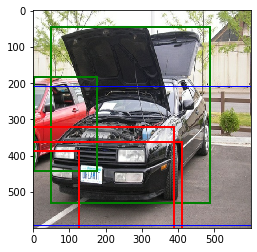

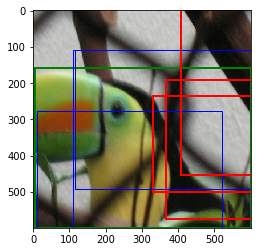

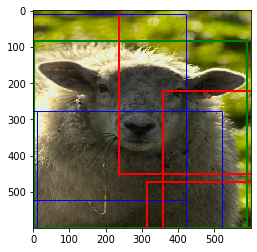

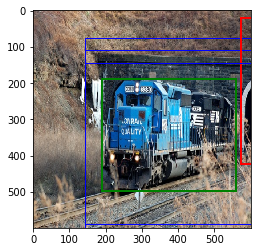

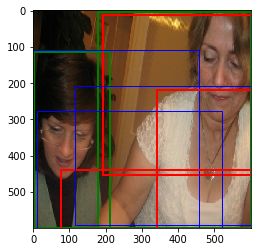

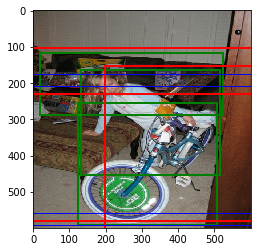

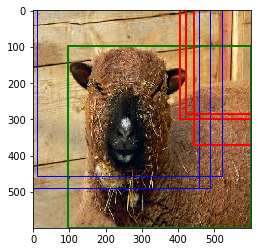

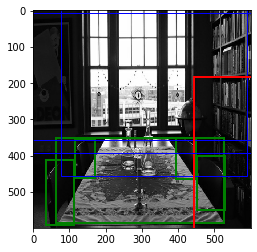

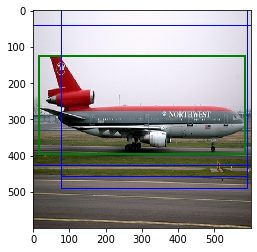

In [13]:
NR_IMAGES = 10
predictions_regr, predictions_class = model.predict(convolutions_output[:NR_IMAGES])

scale = IMG_SIZE / 17
for im, row in enumerate(train.take(NR_IMAGES)):   
    image = row['image'].numpy().astype(float)
    plt.imshow(image)

    ax = plt.gca()

    for bbox, label in zip(row['objects']['bbox'].numpy(), row['objects']['label'].numpy()):
        y_start, x_start, y_finish, x_finish = bbox_perc_to_pixels(bbox)
        
        rect = patches.Rectangle((x_start, y_start), x_finish-x_start, y_finish-y_start, linewidth=2,
                                 edgecolor='green', facecolor='none')
        ax.add_patch(rect)
        
    # select top 3 proposals per image:    
    top3_value = np.sort(predictions_class[im].reshape(-1))[-3]
                
    for i, row in enumerate(anchors_map):
        for j, column in enumerate(row):
            for r, ratio in enumerate(column):
                for s, size in enumerate(ratio):
                    
                    if predictions_class[im][i,j,r*3+s] >= top3_value:
                        
                        distance = predictions_regr[im][i,j].reshape((4,9))[:, r*3+s]
                                                                    
                        groundtruth_x1, groundtruth_y1, groundtruth_width, groundtruth_height = \
                        anchor_and_distance_to_groundtruth(
                            anchors_map['y1'][i,j,r,s], 
                            anchors_map['x1'][i,j,r,s], 
                            anchors_map['y2'][i,j,r,s],
                            anchors_map['x2'][i,j,r,s], distance)
                        
                        rect = patches.Rectangle((groundtruth_x1, groundtruth_y1), 
                                                     groundtruth_width, 
                                                     groundtruth_height, 
                                                     linewidth=2,
                                edgecolor='red', facecolor='none')
                        ax.add_patch(rect)
                    
                    if predictions_class[im][i,j,r*3+s] >= top3_value:
                        rect = patches.Rectangle((anchors_map['x1'][i,j,r,s], anchors_map['y1'][i,j,r,s]), 
                                            anchors_map['x2'][i,j,r,s] - anchors_map['x1'][i,j,r,s], 
                                            anchors_map['y2'][i,j,r,s] - anchors_map['y1'][i,j,r,s],
                                            linewidth=1, edgecolor='blue', facecolor='none')
                        ax.add_patch(rect)
                        
    plt.show()